# Learning to identify the relation between various AI projects using network analysis

In this notebook, our aim is to leverage the graph representation techniques we explored in the previous notebook and apply algorithms such as PageRank, Betweenness Centrality to find the relation between various AI projects and identify the important repositories among them.

## Connect to Augur database

We will be fetching the data from an Augur database which stores the GitHub data for a large number of open source repositories.

In [69]:
import pandas as pd
import itertools
from operator import itemgetter
import sqlalchemy as salc
import json
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

from graph_helper_functions import (
     get_repos,
     get_issue_contributors,
     get_pr_contributors,
     get_commit_contributors,
     get_prr_contributors,
     created_melted_dfs,
     get_page_ranks,
     get_betweenness_centrality,
     get_closeness_centrality,
     plot_graph,
     project_nodes_edges_contributions
)

with open("/Users/pvuda/Development/il_ai_creds.json") as config_file:
    config = json.load(config_file)

In [70]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [71]:
READ_LOCALLY = True

## Retrieve Available Repositories

We start by feeding an initial list of AI projects out of which we track projects in 5 categories:

1. math projects 
2. nlp projects 
3. llm projects 
4. personal_assistants
5. gen_ai

In [72]:
f = open('ai_repos.json')
data = json.load(f)
f.close()

math = data.get('math')
nlp = data.get('nlp')
llm = data.get('llm')
personal_assistants = data.get('personal_assistants')
gen_ai = data.get('gen_ai')

In [73]:
repo_set_math, repo_name_set_math = get_repos(math, engine)
repo_set_nlp, repo_name_set_nlp = get_repos(nlp, engine)
repo_set_llm, repo_name_set_llm = get_repos(llm, engine)
repo_set_personal_assistants, repo_name_Set_personal_assistants = get_repos(personal_assistants, engine)
repo_set_gen_ai, repo_name_set_gen_ai = get_repos(gen_ai, engine)

In [74]:
print(repo_set_math, repo_name_set_math)
print(repo_set_nlp, repo_name_set_nlp)
print(repo_set_llm, repo_name_set_llm)
print(repo_set_personal_assistants, repo_name_Set_personal_assistants)
print(repo_set_gen_ai, repo_name_set_gen_ai)

[25495, 25498, 25497, 25501, 25500, 25504, 25503, 25496, 25502, 25499] ['https://github.com/numpy/numpy', 'https://github.com/tensorflow/tensorflow', 'https://github.com/networkx/networkx', 'https://github.com/pytorch/pytorch', 'https://github.com/keras-team/keras-io', 'https://github.com/tinygrad/tinygrad', 'https://github.com/pandas-dev/pandas', 'https://github.com/polarisss13/polaris', 'https://github.com/apache/arrow', 'https://github.com/ml-explore/mlx']
[25511, 25514, 25515, 25505, 25512, 25516, 25507, 25506, 25510, 25509, 25508, 25513] ['https://github.com/huggingface/transformers', 'https://github.com/explosion/spacy', 'https://github.com/nltk/nltk', 'https://github.com/allenai/allennlp', 'https://github.com/rare-technologies/gensim', 'https://github.com/stanfordnlp/corenlp', 'https://github.com/mozilla/deepspeech', 'https://github.com/facebookresearch/fasttext', 'https://github.com/ukplab/sentence-transformers', 'https://github.com/opennmt/opennmt', 'https://github.com/apache/

In [75]:
org_repo_math = [x.split("https://github.com/", 1)[1] for x in repo_name_set_math]
org_repo_nlp = [x.split("https://github.com/", 1)[1] for x in repo_name_set_nlp]
org_repo_llm = [x.split("https://github.com/", 1)[1] for x in repo_name_set_llm]
org_repo_personal_assistants = [x.split("https://github.com/", 1)[1] for x in repo_name_Set_personal_assistants]
org_repo_gen_ai = [x.split("https://github.com/", 1)[1] for x in repo_name_set_gen_ai]

In [76]:
print(org_repo_math)
print(org_repo_nlp)
print(org_repo_llm)
print(org_repo_personal_assistants)
print(org_repo_gen_ai)

['numpy/numpy', 'tensorflow/tensorflow', 'networkx/networkx', 'pytorch/pytorch', 'keras-team/keras-io', 'tinygrad/tinygrad', 'pandas-dev/pandas', 'polarisss13/polaris', 'apache/arrow', 'ml-explore/mlx']
['huggingface/transformers', 'explosion/spacy', 'nltk/nltk', 'allenai/allennlp', 'rare-technologies/gensim', 'stanfordnlp/corenlp', 'mozilla/deepspeech', 'facebookresearch/fasttext', 'ukplab/sentence-transformers', 'opennmt/opennmt', 'apache/opennlp', 'cogcomp/cogcomp-nlp']
['huggingface/transformers', 'huggingface/datasets', 'huggingface/trl', 'microsoft/deepspeed', 'timdettmers/bitsandbytes', 'mistralai/mistral-common', 'meta-llama/llama', 'google-research/text-to-text-transfer-transformer', 'instructlab/instructlab', 'google-deepmind/gemma']
['mycroftai/mycroft-core', 'laion-ai/open-assistant', 'rhasspy/rhasspy', 'openvoiceos/ovos-core', 'sukeesh/jarvis', 'leon-ai/leon', 'picovoice/porcupine']
['lucidrains/imagen-pytorch', 'langchain-ai/langchain', 'run-llama/llama_index', 'microsoft

In [77]:
org_repo_set = org_repo_math + org_repo_nlp + org_repo_llm + org_repo_personal_assistants + org_repo_gen_ai
repo_set = repo_set_nlp + repo_set_math + repo_set_llm + repo_set_personal_assistants + repo_set_gen_ai

In [78]:
print(org_repo_set)
print(repo_set)

['numpy/numpy', 'tensorflow/tensorflow', 'networkx/networkx', 'pytorch/pytorch', 'keras-team/keras-io', 'tinygrad/tinygrad', 'pandas-dev/pandas', 'polarisss13/polaris', 'apache/arrow', 'ml-explore/mlx', 'huggingface/transformers', 'explosion/spacy', 'nltk/nltk', 'allenai/allennlp', 'rare-technologies/gensim', 'stanfordnlp/corenlp', 'mozilla/deepspeech', 'facebookresearch/fasttext', 'ukplab/sentence-transformers', 'opennmt/opennmt', 'apache/opennlp', 'cogcomp/cogcomp-nlp', 'huggingface/transformers', 'huggingface/datasets', 'huggingface/trl', 'microsoft/deepspeed', 'timdettmers/bitsandbytes', 'mistralai/mistral-common', 'meta-llama/llama', 'google-research/text-to-text-transfer-transformer', 'instructlab/instructlab', 'google-deepmind/gemma', 'mycroftai/mycroft-core', 'laion-ai/open-assistant', 'rhasspy/rhasspy', 'openvoiceos/ovos-core', 'sukeesh/jarvis', 'leon-ai/leon', 'picovoice/porcupine', 'lucidrains/imagen-pytorch', 'langchain-ai/langchain', 'run-llama/llama_index', 'microsoft/lor

### Retrieve Issue Contributors

We will now fetch all Issue contributors for various repositories.

In [79]:
if READ_LOCALLY:

    issue_contrib = pd.read_pickle("data/issue_contrib.pkl")
    issue_contrib['org_repo'] = issue_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    # Assuming issue_contrib is a DataFrame returned by get_issue_contributors function
    issue_contrib = get_issue_contributors(repo_set, engine)

    # Convert the 'created_at' column to datetime if it's not already
    issue_contrib['created_at'] = pd.to_datetime(issue_contrib['created_at'])

    # Extract the date part
    issue_contrib['created_at_dt'] = issue_contrib['created_at'].dt.date

    # Define the date range for filtering
    start_date = pd.to_datetime('2011-01-01').date()
    end_date = pd.to_datetime('2014-06-30').date()

    # Filter the DataFrame using the date range
    date_range = (issue_contrib['created_at_dt'] > start_date) & (issue_contrib['created_at_dt'] <= end_date)
    issue_contrib = issue_contrib.loc[date_range]

    # Create the 'org_repo' column by splitting the 'repo_git' column
    issue_contrib['org_repo'] = issue_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

    # Save the DataFrame to a pickle file
    issue_contrib.to_pickle("data/issue_contrib.pkl")


In [80]:
issue_contrib

,repo_id,repo_git,repo_name,cntrb_id,action,issue_id,created_at,created_at_dt,org_repo
2574,25515,https://github.com/nltk/nltk,nltk,010000d8-6e00-0000-0000-000000000000,closed,65287,2014-06-27 22:40:39,2014-06-27,nltk/nltk
2575,25515,https://github.com/nltk/nltk,nltk,010000d8-6e00-0000-0000-000000000000,closed,65289,2014-06-25 14:15:54,2014-06-25,nltk/nltk
2576,25515,https://github.com/nltk/nltk,nltk,010000d8-6e00-0000-0000-000000000000,closed,65291,2014-06-18 08:38:05,2014-06-18,nltk/nltk
2577,25515,https://github.com/nltk/nltk,nltk,010000d8-6e00-0000-0000-000000000000,closed,65295,2014-05-11 03:20:09,2014-05-11,nltk/nltk
2578,25515,https://github.com/nltk/nltk,nltk,010000d8-6e00-0000-0000-000000000000,closed,65300,2014-04-20 22:49:18,2014-04-20,nltk/nltk
...,...,...,...,...,...,...,...,...,...
14791,25497,https://github.com/networkx/networkx,networkx,01000df6-5d00-0000-0000-000000000000,closed,39394,2012-07-20 23:41:56,2012-07-20,networkx/networkx
14792,25497,https://github.com/networkx/networkx,networkx,01000df6-5d00-0000-0000-000000000000,closed,39283,2013-03-28 10:48:47,2013-03-28,networkx/networkx
14793,25497,https://github.com/networkx/networkx,networkx,01000df6-5d00-0000-0000-000000000000,closed,39317,2012-09-27 10:05:29,2012-09-27,networkx/networkx
14809,25497,https://github.com/networkx/networkx,networkx,01000df6-5d00-0000-0000-000000000000,closed,39206,2014-01-28 21:49:26,2014-01-28,networkx/networkx


### Retrieve PR Contributors

We will now fetch all the PR contributors for various repositories.

In [81]:
if READ_LOCALLY:

    pr_contrib = pd.read_pickle("data/pr_contrib.pkl")
    pr_contrib['org_repo'] = pr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    # Assuming pr_contrib is a DataFrame returned by get_pr_contributors function
    pr_contrib = get_pr_contributors(repo_set, engine)

    # Convert the 'pr_created_at' column to datetime if it's not already
    pr_contrib['pr_created_at'] = pd.to_datetime(pr_contrib['pr_created_at'])

    # Extract the date part
    pr_contrib['created_at_dt'] = pr_contrib['pr_created_at'].dt.date

    # Define the date range for filtering
    start_date = pd.to_datetime('2011-01-01').date()
    end_date = pd.to_datetime('2014-06-30').date()

    # Filter the DataFrame using the date range
    date_range = (pr_contrib['created_at_dt'] > start_date) & (pr_contrib['created_at_dt'] <= end_date)
    pr_contrib = pr_contrib.loc[date_range]

    # Create the 'org_repo' column by splitting the 'repo_git' column
    pr_contrib['org_repo'] = pr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

    # Save the DataFrame to a pickle file
    pr_contrib.to_pickle("data/pr_contrib.pkl")


In [82]:
pr_contrib

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,pr_created_at,created_at_dt,org_repo
40881,25515,https://github.com/nltk/nltk,nltk,010004d0-0e00-0000-0000-000000000000,70706,2013-02-27 21:22:59,2013-02-27,nltk/nltk
40882,25515,https://github.com/nltk/nltk,nltk,010001e4-d200-0000-0000-000000000000,70706,2013-02-27 21:22:59,2013-02-27,nltk/nltk
40883,25515,https://github.com/nltk/nltk,nltk,010023bc-1d00-0000-0000-000000000000,70545,2014-04-26 06:26:44,2014-04-26,nltk/nltk
40884,25515,https://github.com/nltk/nltk,nltk,010001e4-d200-0000-0000-000000000000,70545,2014-04-26 06:26:44,2014-04-26,nltk/nltk
40885,25515,https://github.com/nltk/nltk,nltk,010001a5-7500-0000-0000-000000000000,70695,2013-03-27 20:43:38,2013-03-27,nltk/nltk
...,...,...,...,...,...,...,...,...
411912,25503,https://github.com/pandas-dev/pandas,pandas,01014397-c000-0000-0000-000000000000,857468,2014-01-28 06:01:06,2014-01-28,pandas-dev/pandas
411913,25503,https://github.com/pandas-dev/pandas,pandas,01005539-4500-0000-0000-000000000000,857469,2014-02-12 19:40:00,2014-02-12,pandas-dev/pandas
411914,25503,https://github.com/pandas-dev/pandas,pandas,01014397-c000-0000-0000-000000000000,857469,2014-02-12 19:40:00,2014-02-12,pandas-dev/pandas
413239,25503,https://github.com/pandas-dev/pandas,pandas,010022c8-ae00-0000-0000-000000000000,271827,2014-04-14 21:29:37,2014-04-14,pandas-dev/pandas


### Retrieve Commit Contributors

We will now fetch all the Commit contributors for various repositories.

In [83]:
if READ_LOCALLY:
    
    commit_contrib = pd.read_pickle("data/commit_contrib.pkl")
    commit_contrib['org_repo'] = commit_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:
    
    # Assuming commit_contrib is a DataFrame returned by get_commit_contributors function
    commit_contrib = get_commit_contributors(repo_set, engine)

    # Convert the 'cmt_date_attempted' column to datetime if it's not already
    commit_contrib['cmt_date_attempted'] = pd.to_datetime(commit_contrib['cmt_date_attempted'])

    # Extract the date part
    commit_contrib['cmt_date_attempted_dt'] = commit_contrib['cmt_date_attempted'].dt.date

    # Define the date range for filtering
    start_date = pd.to_datetime('2011-01-01').date()
    end_date = pd.to_datetime('2014-06-30').date()

    # Filter the DataFrame using the date range
    date_range = (commit_contrib['cmt_date_attempted_dt'] > start_date) & (commit_contrib['cmt_date_attempted_dt'] <= end_date)
    commit_contrib = commit_contrib.loc[date_range]

    # Create the 'org_repo' column by splitting the 'repo_git' column
    commit_contrib['org_repo'] = commit_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

    # Save the DataFrame to a pickle file
    commit_contrib.to_pickle("data/commit_contrib.pkl")


In [84]:
commit_contrib

,repo_id,repo_git,repo_name,cntrb_id,cmt_id,cmt_date_attempted,cmt_date_attempted_dt,org_repo
119341,25515,https://github.com/nltk/nltk,nltk,0100051e-1700-0000-0000-000000000000,2226071,2012-05-18,2012-05-18,nltk/nltk
119342,25515,https://github.com/nltk/nltk,nltk,0100051e-1700-0000-0000-000000000000,2226072,2012-05-18,2012-05-18,nltk/nltk
119343,25515,https://github.com/nltk/nltk,nltk,0100051e-1700-0000-0000-000000000000,2233657,2012-05-18,2012-05-18,nltk/nltk
119344,25515,https://github.com/nltk/nltk,nltk,0100051e-1700-0000-0000-000000000000,2233692,2012-05-18,2012-05-18,nltk/nltk
119345,25515,https://github.com/nltk/nltk,nltk,0100051e-1700-0000-0000-000000000000,2233693,2012-05-18,2012-05-18,nltk/nltk
...,...,...,...,...,...,...,...,...
2608047,25496,https://github.com/polarisss13/polaris,polaris,010002de-0700-0000-0000-000000000000,3610484,2012-02-02,2012-02-02,polarisss13/polaris
2608049,25496,https://github.com/polarisss13/polaris,polaris,010013d7-2200-0000-0000-000000000000,3610497,2013-02-15,2013-02-15,polarisss13/polaris
2608055,25496,https://github.com/polarisss13/polaris,polaris,01000dc4-4300-0000-0000-000000000000,3610494,2012-06-22,2012-06-22,polarisss13/polaris
2608056,25496,https://github.com/polarisss13/polaris,polaris,01000dc4-4300-0000-0000-000000000000,3610502,2012-02-25,2012-02-25,polarisss13/polaris


### Retrieve PR Reviewers 

We will now fetch all the PR Reviewers for various repositories.

In [85]:
if READ_LOCALLY:

    prr_contrib = pd.read_pickle("data/prr_contrib.pkl")
    prr_contrib['org_repo'] = prr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])

else:

    prr_contrib = get_prr_contributors(repo_set, engine)
    prr_contrib['org_repo'] = prr_contrib['repo_git'].apply(lambda x: x.split("https://github.com/", 1)[1])
    prr_contrib.to_pickle("data/prr_contrib.pkl")  

In [86]:
prr_contrib

,repo_id,repo_git,repo_name,cntrb_id,pull_request_id,org_repo
0,25511,https://github.com/huggingface/transformers,transformers,0101d54b-c200-0000-0000-000000000000,271912,huggingface/transformers
1,25511,https://github.com/huggingface/transformers,transformers,01059856-a700-0000-0000-000000000000,143133,huggingface/transformers
2,25511,https://github.com/huggingface/transformers,transformers,0100bac7-cc00-0000-0000-000000000000,151141,huggingface/transformers
3,25511,https://github.com/huggingface/transformers,transformers,0100c453-fa00-0000-0000-000000000000,143182,huggingface/transformers
4,25511,https://github.com/huggingface/transformers,transformers,01038b52-d500-0000-0000-000000000000,143189,huggingface/transformers
...,...,...,...,...,...,...
227435,25539,https://github.com/automatic1111/stable-diffus...,stable-diffusion-webui,01013f38-aa00-0000-0000-000000000000,111316,automatic1111/stable-diffusion-webui
227436,25539,https://github.com/automatic1111/stable-diffus...,stable-diffusion-webui,01013f38-aa00-0000-0000-000000000000,111347,automatic1111/stable-diffusion-webui
227437,25539,https://github.com/automatic1111/stable-diffus...,stable-diffusion-webui,01021a4d-b400-0000-0000-000000000000,111399,automatic1111/stable-diffusion-webui
227438,25539,https://github.com/automatic1111/stable-diffus...,stable-diffusion-webui,010018ee-3400-0000-0000-000000000000,111504,automatic1111/stable-diffusion-webui


## Graph Type 1: Projects and Contributors as Nodes

In this section, we plot projects and contributors on the same graph as nodes and color them differently to see the relationships between them.

### Commit Contributors

In [87]:
df_commit = commit_contrib.groupby(['org_repo', 'cntrb_id']).size().unstack(fill_value=0)
df_commit.head()

cntrb_id,01000004-cf00-0000-0000-000000000000,01000006-6900-0000-0000-000000000000,01000007-8900-0000-0000-000000000000,01000009-bb00-0000-0000-000000000000,0100000a-5400-0000-0000-000000000000,01000021-5100-0000-0000-000000000000,01000024-a000-0000-0000-000000000000,01000026-b200-0000-0000-000000000000,0100002e-5400-0000-0000-000000000000,01000045-c900-0000-0000-000000000000,...,010141cf-d800-0000-0000-000000000000,01017a8e-5800-0000-0000-000000000000,01019c9b-1700-0000-0000-000000000000,010286eb-9700-0000-0000-000000000000,01028ec9-4b00-0000-0000-000000000000,01038304-c400-0000-0000-000000000000,010477a3-ee00-0000-0000-000000000000,010696c5-e100-0000-0000-000000000000,01076eed-7300-0000-0000-000000000000,010a45e6-4c00-0000-0000-000000000000
org_repo,,,,,,,,,,,,,,,,,,,,,
apache/opennlp,0,0,0,0,0,0,0,0,0,0,...,0,0,120,0,0,0,0,0,0,0
networkx/networkx,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,7,0,0,0,0
nltk/nltk,0,0,0,0,0,1,0,2,0,2,...,0,18,0,0,0,0,0,0,0,0
numpy/numpy,0,0,1,0,0,0,0,0,0,0,...,5,0,0,0,2,0,0,0,0,0
pandas-dev/pandas,0,0,0,0,2,0,2,0,2,0,...,14,0,0,0,0,0,16,10,0,0


In the above dataframe, each row represents a repository ID and each column represents a contributor. The dataframe contains counts for the number of times a contributor has made contributions to a particular repository. In the dataframe below `df_commit`, each contribution represents a commit. A value 0 means that a particular contributor has made no commits to the repository, and a number x means that the contributor has made x number of commits to the repository.

In [88]:
df_commit = df_commit.reset_index()
df_melted_commit = df_commit.melt(
    ['org_repo'],
    var_name = 'cntrb_id',value_name='number')
df_melted_commit = df_melted_commit[df_melted_commit[df_melted_commit.columns[2]] != 0]
df_melted_commit

,org_repo,cntrb_id,number
7,rare-technologies/gensim,01000004-cf00-0000-0000-000000000000,2
16,rare-technologies/gensim,01000006-6900-0000-0000-000000000000,3
21,numpy/numpy,01000007-8900-0000-0000-000000000000,1
34,rare-technologies/gensim,01000009-bb00-0000-0000-000000000000,4
40,pandas-dev/pandas,0100000a-5400-0000-0000-000000000000,2
...,...,...,...
5986,networkx/networkx,01038304-c400-0000-0000-000000000000,7
5998,pandas-dev/pandas,010477a3-ee00-0000-0000-000000000000,16
6007,pandas-dev/pandas,010696c5-e100-0000-0000-000000000000,10
6017,polarisss13/polaris,01076eed-7300-0000-0000-000000000000,45


In `df_melted_commit` we transpose the contributor IDs. Each row is a combination of a unique repository and a unique contributor and the number represents the number of times the contributor has made contributors to the particular repository.

#### Create melted dataframes for all contribution type dataframes

In [89]:
df_melted_pr_contrib = created_melted_dfs(pr_contrib)
df_melted_issue_contrib = created_melted_dfs(issue_contrib)
df_melted_prr_contrib = created_melted_dfs(prr_contrib)

### Join repositories of all contribution types

Combine dataframes of Issue contributors, PR contributors, PR Reviewers, and Commit Contributors to get aggregated contributor dataframes for each repository

In [90]:
commit_issue = pd.concat([df_melted_commit, df_melted_issue_contrib]).groupby(["org_repo", "cntrb_id"]).sum().reset_index()
comm_issue_pr_df = pd.concat([df_melted_pr_contrib, commit_issue]).groupby(["org_repo", "cntrb_id"]).sum().reset_index()
merged_df = pd.concat([comm_issue_pr_df, df_melted_prr_contrib]).groupby(["org_repo", "cntrb_id"]).sum().reset_index()
merged_df.rename(columns = {'number':'total_contributions'}, inplace = True)

In [128]:
merged_df

,org_repo,cntrb_id,total_contributions
0,allenai/allennlp,01000975-4400-0000-0000-000000000000,10
1,allenai/allennlp,01000c3a-ab00-0000-0000-000000000000,2
2,allenai/allennlp,01000e0c-3e00-0000-0000-000000000000,53
3,allenai/allennlp,01000e91-ae00-0000-0000-000000000000,42
4,allenai/allennlp,010013f6-9900-0000-0000-000000000000,41
...,...,...,...
3063,tinygrad/tinygrad,0101190c-6300-0000-0000-000000000000,1
3064,tinygrad/tinygrad,01018327-c500-0000-0000-000000000000,3
3065,tinygrad/tinygrad,0108442a-e900-0000-0000-000000000000,1
3066,ukplab/sentence-transformers,0100a360-1100-0000-0000-000000000000,4


### Plot Graphs

### Use PageRank and Betweenness Centrality to Subset Nodes

We can now try to run the `PageRank` algorithm to compute the ranking of the nodes in the graph based on the structure of the incoming links. 

We will also look into the betweenness centrality in the graph to compute the shortest-path betweenness centrality for nodes. It measures how often a node occurs on all shortest paths between two nodes. Here we are trying to analyze which are the common repositories that occur on all paths in the graph. 

### Page Rank

PageRank ranks important nodes by analyzing the quantity and quality of the links that point to it. In our case, links that point to repositories come from contributors. 

In [92]:
repo_scores = pd.DataFrame(
    {'repo': org_repo_math + org_repo_nlp + org_repo_llm + org_repo_personal_assistants + org_repo_gen_ai
    })

In [93]:
#  A unidirected graph from contributors to repositories will not be able to assign importances to well connected contributors. 
#  Hence we will create a bidirected graph where for each connection between a contributor and a repository, there is a 2 way arrow.
# bidirect_df = merged_df.append(merged_df.rename(columns={"org_repo":"cntrb_id", "cntrb_id":"org_repo"}))

# Create the renamed DataFrame
renamed_df = merged_df.rename(columns={"org_repo": "cntrb_id", "cntrb_id": "org_repo"})

# Concatenate the original DataFrame with the renamed DataFrame
bidirect_df = pd.concat([merged_df, renamed_df])

In [94]:
# Creating a directed graph to run page rank
H = nx.from_pandas_edgelist(bidirect_df,
                            source='cntrb_id',
                            target='org_repo',
                            edge_attr='total_contributions',
                            create_using=nx.DiGraph())

In [95]:
repos = {
            "repo_name_set_math": org_repo_math, 
            "repo_name_set_nlp": org_repo_nlp, 
            "repo_name_set_llm": org_repo_llm, 
            "repo_name_set_personal_assistants": org_repo_personal_assistants,
            "repo_name_set_gen_ai": org_repo_gen_ai
        }

In [96]:
top_repos, pageranks, repo_scores = get_page_ranks(H, 100, repos, repo_scores)

In [97]:
topnodes = dict(sorted(pageranks.items(), key = itemgetter(1), reverse = True)[:50])
key = topnodes.keys()
subgraph = nx.subgraph(H, key)

We want to give higher priority to outgoing nodes. So we take 50 nodes with lowest pagerank (most number of connections)

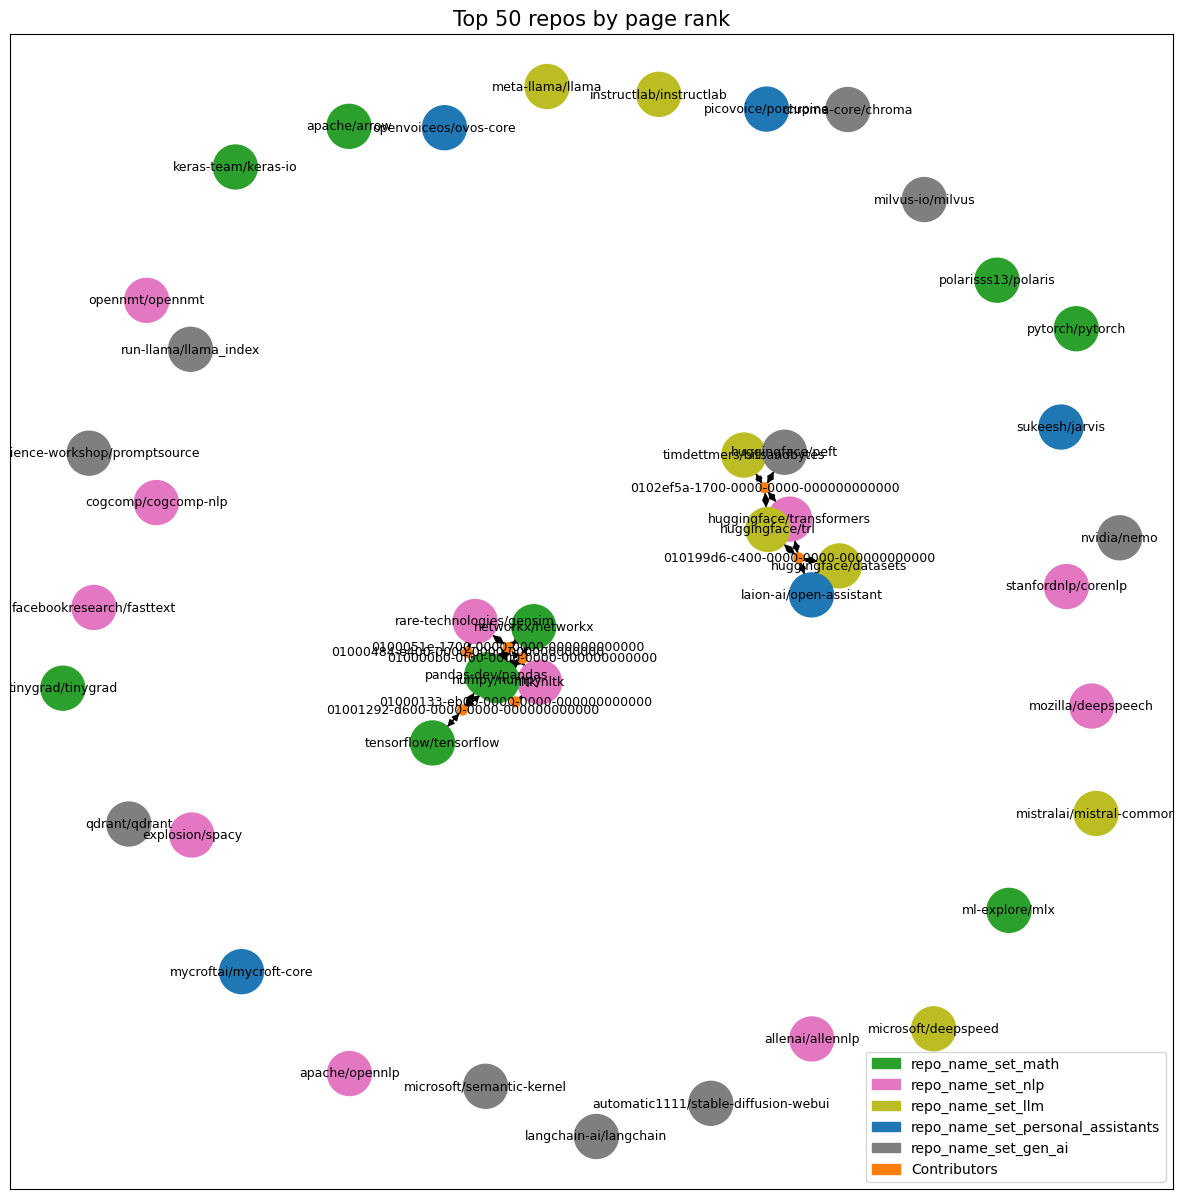

In [130]:
t = "Top 50 repos by page rank"
plot_graph(subgraph, repos, 'conditional', t, org_repo_set , True, None, 'k')

***What do we see in this plot?***

We see the top 50 nodes in the graph, which include both the project nodes and the contributors.
The PageRank algorithm measures the importance of nodes by analyzing the quantity and quality of the links that point to it. So if a repository has a lot of contributors and especially if these contributors count as important nodes, they are still ranked high.

### Betweenness centrality

Betweenness centrality analysis provides information about the node’s importance for an information flow or connectivity of the network. 
This is a good metric for us, as using this we are able to better capture relative importance of repositories. In our case since we start with examples of well-known repos, we can use this algorithm to find other repos which are important in connection to these well-known repos.

In [100]:
G = nx.from_pandas_edgelist(merged_df, 
                            source='org_repo',
                            target='cntrb_id',
                            edge_attr='total_contributions',
                            create_using=nx.Graph())

In [101]:
top_repos, bc, repo_scores = get_betweenness_centrality(G, 50, repos, repo_scores)

In [137]:
top_repos

,repo,page_rank,betweenness_centrality,closeness_centrality,category,total_score
3,pytorch/pytorch,1.000000,1.000000,1.000000,repo_name_set_math,3.000000
1,tensorflow/tensorflow,0.682474,0.792936,0.733108,repo_name_set_math,2.208519
0,numpy/numpy,0.499356,0.709209,0.658378,repo_name_set_math,1.866943
6,pandas-dev/pandas,0.575921,0.640185,0.495332,repo_name_set_math,1.711438
12,nltk/nltk,0.179513,0.226213,0.902948,repo_name_set_nlp,1.308674
10,huggingface/transformers,0.118564,0.138343,0.495332,repo_name_set_nlp,0.752238
22,huggingface/transformers,0.118564,0.138343,0.495332,repo_name_set_nlp,0.752238
26,timdettmers/bitsandbytes,0.005130,0.072578,0.623211,repo_name_set_llm,0.700919
2,networkx/networkx,0.174257,0.158248,0.334958,repo_name_set_math,0.667463
14,rare-technologies/gensim,0.098500,0.095869,0.438122,repo_name_set_nlp,0.632491


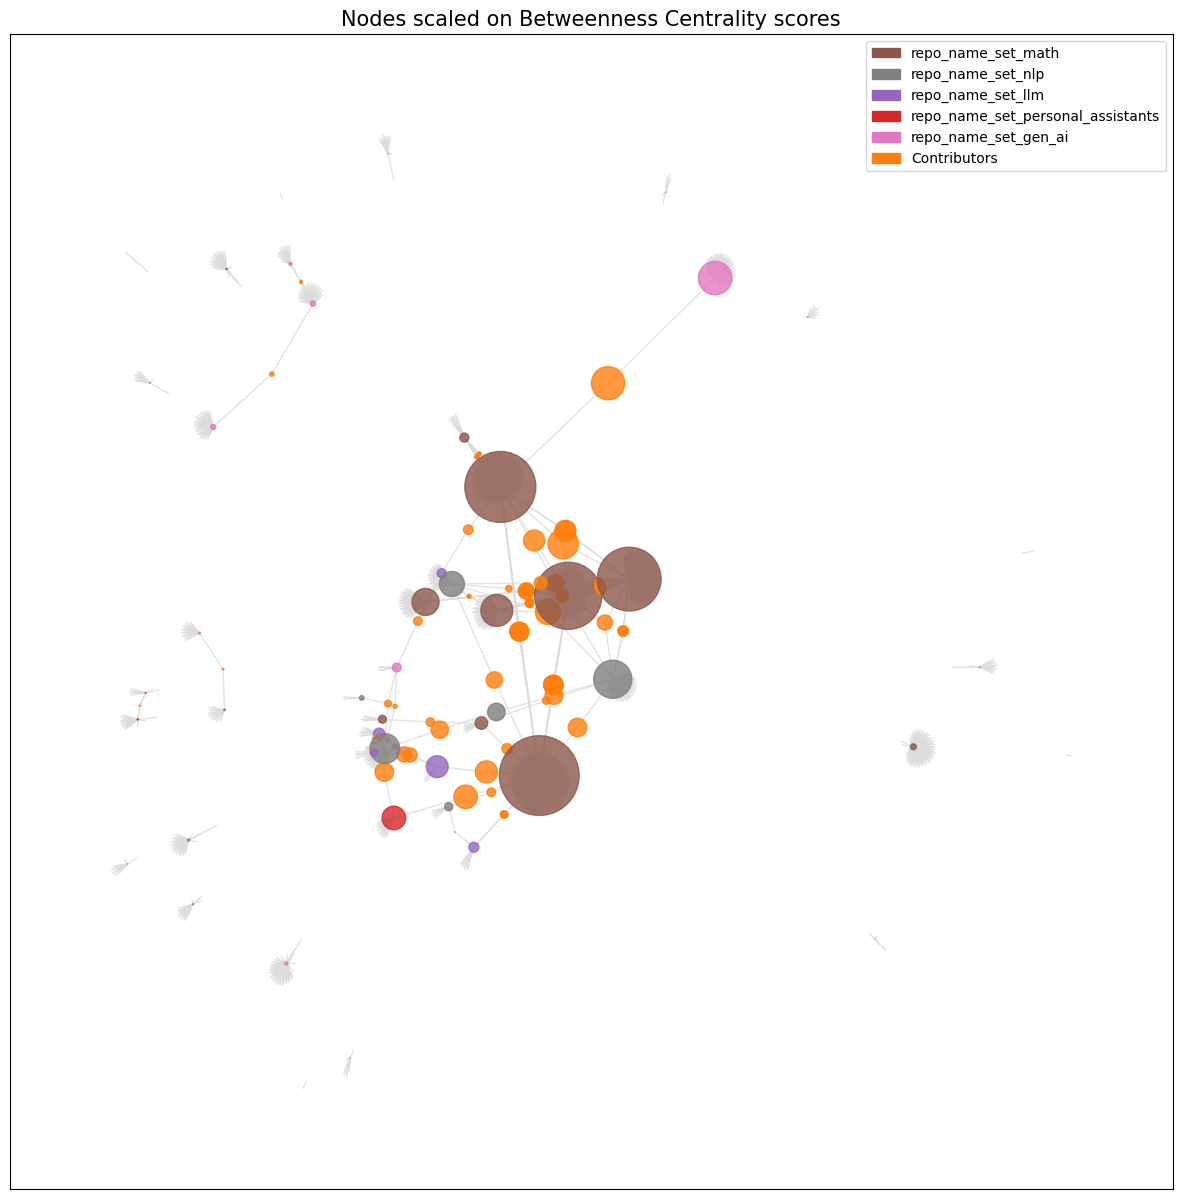

In [136]:
t = "Nodes scaled on Betweenness Centrality scores"
plot_graph(G, repos, 'weighted', t, bc , False, 0.8, "gainsboro")

***What do we see in this plot?***

The size of the nodes in the plot above indicate higher centrality scores. We see that the centrality scores highly rank the math repos. 

Betweenness Centrality gives us good results and is highly ranking math repos in comparison to other community repos as this algorithm is able to better capture relative importance of repositories. 

By starting off with well-known/math repos, centrality is able to help us disvover other repos which are important in connection to these well-known/math repos.

## Graph Type 2: Nodes as projects edges as contributors

In this section, we represent data in another graph representation where the project repositories are represented by nodes and the edges are shared contributions between those projects

In [103]:
result, common_repo_contri = project_nodes_edges_contributions(merged_df)

For plotting the graph below, we pick the repositories as the nodes and let the shared contributions dictate the edge weights

In [133]:
g = nx.Graph()
g.add_weighted_edges_from(result)

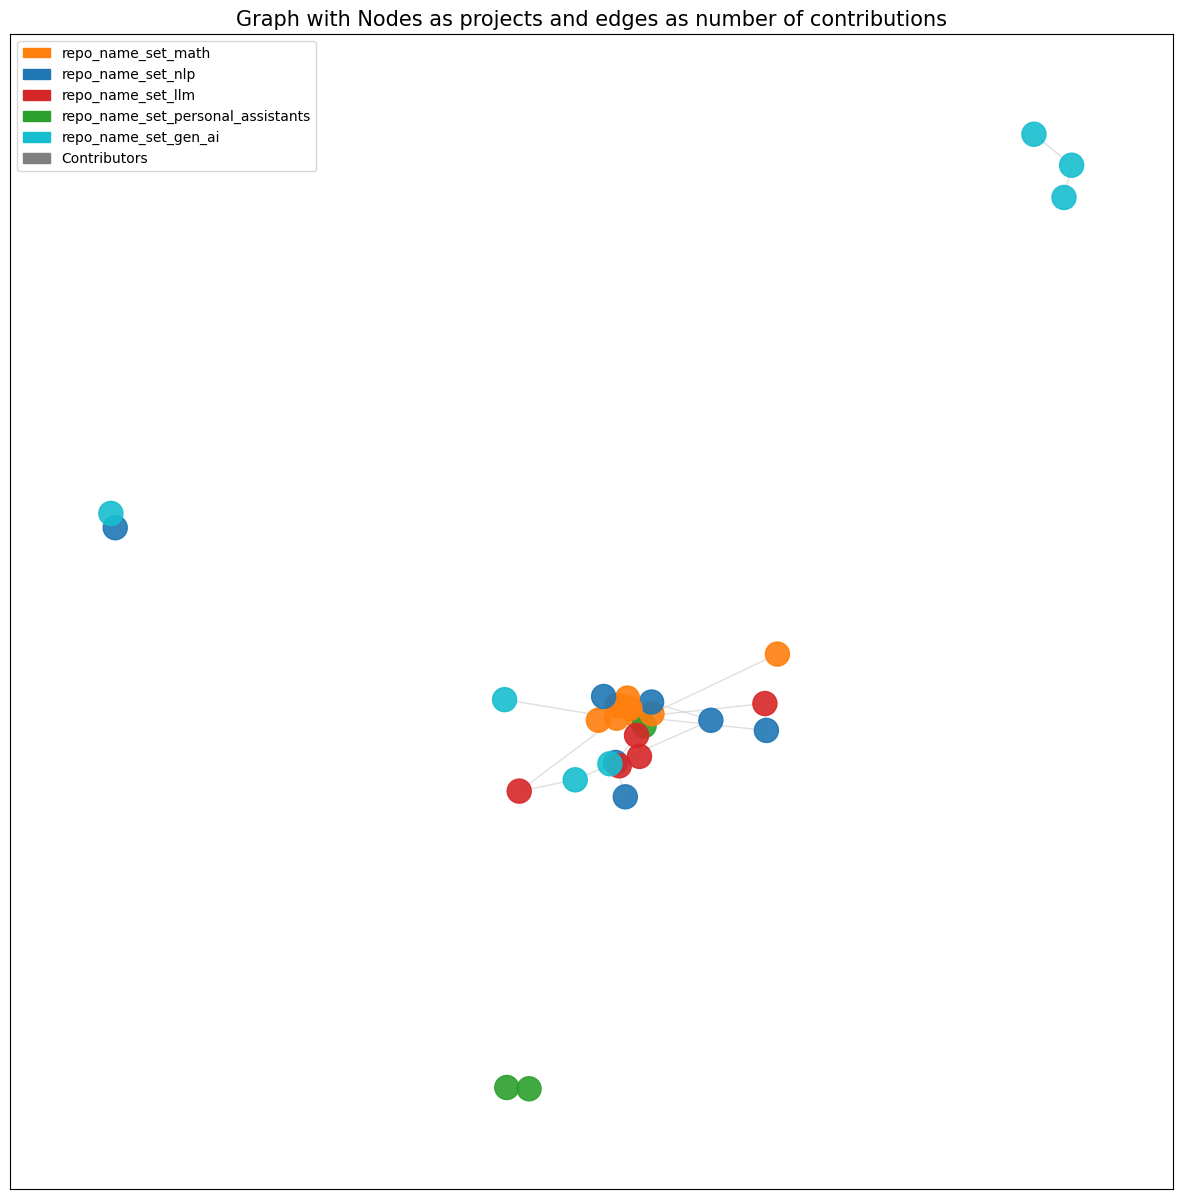

In [134]:
t = "Graph with Nodes as projects and edges as number of contributions"
plot_graph(g, repos, 'equal', t, None , False, 0.9, "gainsboro")

***What do we see in this plot?***

The above graph represents project repositories and how close or far they are to each other based on their degree of connection (number of shared contributions amongst them). If 2 nodes are close to each other, the 2 projects have a high number of shared contributions and vice versa. Each node in this graph has atleast one connection. We only plot project repositories which are connected to existing known repositories.  

We see that this graph representation effectively filters out the repositories we are most interested in seeing. **The repository "closest" to the "math projects" are mainly "nlp projects" and a few "llm projects".** This indicates that the more developed and established projects are central in the graph and the lesser known projects are emerging from it.

The edge lengths and the distance between the nodes can be used to filter out the most connected repos that we are interested in.

Thus, this graph representation turns out to be an effective way to filter out emerging repositories in relation to already prominent communities.

### Lets eliminate the 30% of the furthest connections

In [106]:
sorted_contribution_dict = dict(sorted(common_repo_contri.items(), key=lambda item: item[1], reverse=True))

In [107]:
tightly_connected_repos = dict(itertools.islice(sorted_contribution_dict.items(), round(0.7*len(sorted_contribution_dict))))

In [108]:
len(tightly_connected_repos)

31

### Community Detection

To get groups of clusters, lets look at larger congregations with more than 5 projects to get a cleaner view into the main networks

In [109]:
graphs = [g.subgraph(c) for c in nx.connected_components(g)]

In [110]:
sub_graphs = []
for g in graphs:
    n = g.nodes()
    if g.number_of_nodes() > 5 and (set(n) & set(org_repo_llm)):
        sub_graphs.append(g)

In [111]:
sub_graphs

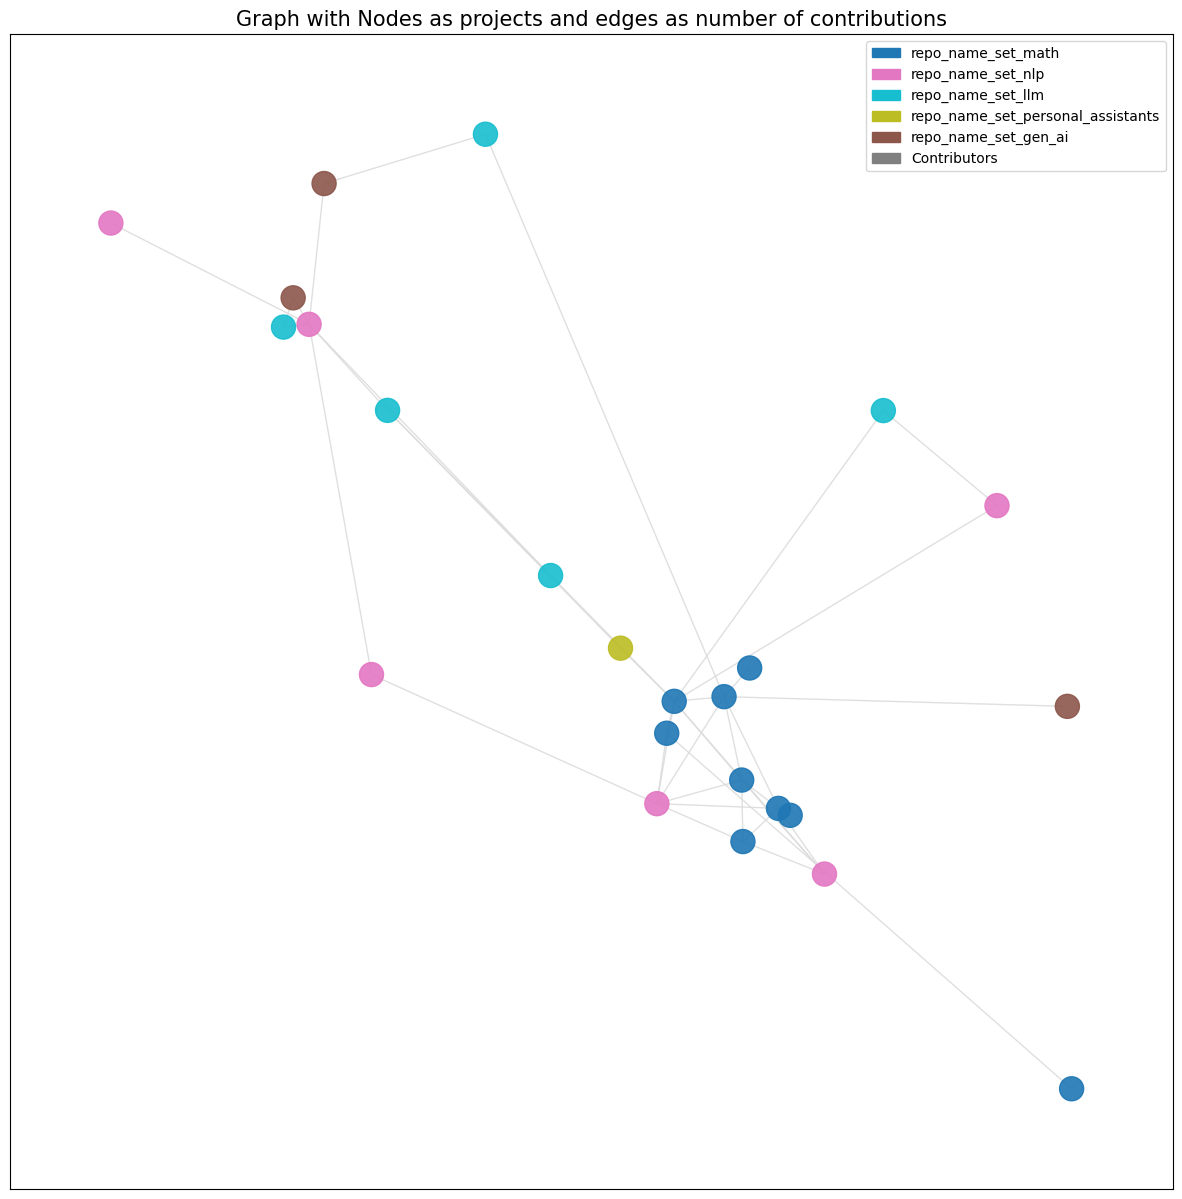

In [112]:
for graph in sub_graphs:
    plot_graph(graph, repos, 'equal', t, None , False, 0.9, "gainsboro")

***What do we see in this plot?***

We see that in this case, the above graph is similar to the previous one. Ideally, this plot will help us further narrow down on the more densely conected nodes in the graph to better identify the user community around them. By identifying the cluster of similar user groups around projects, we can better track and understand the Open Source community growth.

## Storing the Centrality Scores

Let's calculate the centrality scores for our math, nlp and llm projects and identify our "top" projects.

In [113]:
top_repos, cc, repo_scores = get_closeness_centrality(sub_graphs[0], 100, repos, repo_scores)

In [114]:
repo_scores

,repo,page_rank,betweenness_centrality,closeness_centrality
0,numpy/numpy,0.047195,2.336845e-01,0.460000
1,tensorflow/tensorflow,0.064392,2.611458e-01,0.479167
2,networkx/networkx,0.016665,5.297694e-02,0.377049
3,pytorch/pytorch,0.094211,3.290598e-01,0.547619
4,keras-team/keras-io,0.002305,4.293397e-03,0.328571
5,tinygrad/tinygrad,0.001172,3.218328e-03,0.291139
6,pandas-dev/pandas,0.054385,2.110454e-01,0.418182
7,polarisss13/polaris,0.019745,1.805538e-03,NaN
8,apache/arrow,0.011559,3.807553e-02,0.298701
9,ml-explore/mlx,0.001521,8.114115e-03,0.403509


### Top most interesting repos in each category based on the above scores

In [115]:
repo_scores = repo_scores.dropna(axis=0)

In [116]:
def category(col_val, repo_dict):
    for repo_group in repo_dict:
        if col_val in repo_dict[repo_group]:
            return repo_group

In [117]:
repo_scores['category'] = repo_scores['repo'].apply(lambda row: category(row, repos))

/var/folders/7w/mm9ktp7n75dgn8rjth6_zv_m0000gn/T/ipykernel_64903/1311338015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  repo_scores['category'] = repo_scores['repo'].apply(lambda row: category(row, repos))


In [118]:
scaler = MinMaxScaler()

def calculate_scores(df):
    df[['page_rank', 'betweenness_centrality', 'closeness_centrality']] = scaler.fit_transform(df[['page_rank', 'betweenness_centrality', 'closeness_centrality']])
    df['total_score'] = df.apply(lambda row: row.page_rank + row.betweenness_centrality + row.closeness_centrality, axis = 1)
    return df

In [119]:
repo_scores = calculate_scores(repo_scores)

/var/folders/7w/mm9ktp7n75dgn8rjth6_zv_m0000gn/T/ipykernel_64903/1876849534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['page_rank', 'betweenness_centrality', 'closeness_centrality']] = scaler.fit_transform(df[['page_rank', 'betweenness_centrality', 'closeness_centrality']])
/var/folders/7w/mm9ktp7n75dgn8rjth6_zv_m0000gn/T/ipykernel_64903/1876849534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_score'] = df.apply(lambda row: row.page_rank + row.betweenness_centrality + row.closen

In [120]:
repo_scores

,repo,page_rank,betweenness_centrality,closeness_centrality,category,total_score
0,numpy/numpy,0.499356,0.709209,0.658378,repo_name_set_math,1.866943
1,tensorflow/tensorflow,0.682474,0.792936,0.733108,repo_name_set_math,2.208519
2,networkx/networkx,0.174257,0.158248,0.334958,repo_name_set_math,0.667463
3,pytorch/pytorch,1.000000,1.000000,1.000000,repo_name_set_math,3.000000
4,keras-team/keras-io,0.021350,0.009817,0.145946,repo_name_set_math,0.177113
5,tinygrad/tinygrad,0.009287,0.006539,0.000000,repo_name_set_math,0.015826
6,pandas-dev/pandas,0.575921,0.640185,0.495332,repo_name_set_math,1.711438
8,apache/arrow,0.119889,0.112815,0.029484,repo_name_set_math,0.262188
9,ml-explore/mlx,0.013002,0.021466,0.438122,repo_name_set_math,0.472590
10,huggingface/transformers,0.118564,0.138343,0.495332,repo_name_set_nlp,0.752238


In [121]:
NUMBER_OF_TOP_REPOS = 5

In [122]:
top_repos = repo_scores.sort_values("total_score", ascending=False).groupby("category").head(NUMBER_OF_TOP_REPOS)

In [123]:
top_repos.loc[top_repos['category'] == 'repo_name_set_math', 'repo']

3          pytorch/pytorch
1    tensorflow/tensorflow
0              numpy/numpy
6        pandas-dev/pandas
2        networkx/networkx
Name: repo, dtype: object

In [124]:
top_repos.loc[top_repos['category'] == 'repo_name_set_nlp', 'repo']

12                       nltk/nltk
10        huggingface/transformers
22        huggingface/transformers
14        rare-technologies/gensim
18    ukplab/sentence-transformers
Name: repo, dtype: object

In [125]:
top_repos.loc[top_repos['category'] == 'repo_name_set_llm', 'repo']

26                             timdettmers/bitsandbytes
29    google-research/text-to-text-transfer-transformer
28                                     meta-llama/llama
24                                      huggingface/trl
23                                 huggingface/datasets
Name: repo, dtype: object

In [126]:
top_repos.loc[top_repos['category'] == 'repo_name_set_personal_assistants', 'repo']

33    laion-ai/open-assistant
Name: repo, dtype: object

In [127]:
top_repos.loc[top_repos['category'] == 'repo_name_set_gen_ai', 'repo']

43                         nvidia/nemo
49    bigscience-workshop/promptsource
44                    huggingface/peft
Name: repo, dtype: object

# Conclusion

In this notebook, we ran an experiment on known open source AI repositories. We looked at a timeframe in history where a new open source community was emerging/becoming popular and we tried to track the rise of the community using graph alrgorithms.

As an example, we wanted to track the emergence of "nlp" and "llm" projects in relation to the already well known "math" projects. So we fetched the GitHub data for various repos in each of the 5 AI category of projects, with the hope that as a result of the analysis, the nlp or llm projects would emerge as the community closest in connection to the math projects.

As a result of creating various types of graphical representations of the Github data and using algorithms like PageRank and Betweenness centrality, we saw that:

1. **PageRank is not effective in showing us important emerging repositories**

2. **Using Betweenness Centrality ranks, we are able to get pytorch, tensorflow, numpy, pandas repos in the top most highly ranked or central repos.**

3. **Using the graph representation type 2 where we represent nodes as projects and edges as contributors, we are able to very effectively filter out the repositories we are most interested in seeing.**